# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use model selection for performing some simple analysis on real neural signals. 

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders
* Select the optimal model via cross-validation

The last stage of the lab uses LASSO estimation for model selection.  If you are doing this part of the lab, you should review the concepts in [LASSO demonstration](./prostate.ipynb) on the prostate cancer  dataset.  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the basic packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [2]:
import scipy.io
mat_dict = scipy.io.loadmat('StevensonV2.mat')

The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [3]:
#TODO
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

We extract two variables, `spikes` and `handVel`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand velocity.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handVel` data, we take the first component which is the motion in the $x$-direction.

In [4]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handVel'][0,:]

The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [5]:
# TODO 
nt, nneuron = X0.shape
print("nt: %s" %nt)
print("nneuron: %s" %nneuron)

nt: 15536
nneuron: 196


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [6]:
# TODO
time = mat_dict['time'].T
tsamp = time[1] - time[0]
timeCount, _ = time.shape
ttotal = time[timeCount-1] - time[0]
print("tsamp: %f" %tsamp)
print("ttotal: %f" %ttotal)

tsamp: 0.050000
ttotal: 776.750000


## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [7]:
# TODO
half = X0.shape[0] //2

Xtr = X0[:half]
ytr = y0[:half]
Xts = X0[half:]
yts = y0[half:]
print("Xtr: \n", Xtr)
print("ytr: \n", ytr)
print("Xts: \n", Xts)
print("yts: \n", yts)

Xtr: 
 [[1 0 2 ..., 2 0 2]
 [3 1 1 ..., 0 0 0]
 [1 0 1 ..., 0 0 3]
 ..., 
 [1 0 0 ..., 0 0 6]
 [0 0 0 ..., 0 0 5]
 [0 0 0 ..., 0 0 2]]
ytr: 
 [-0.0112006  -0.01074321  0.01767953 ..., -0.00575783  0.00273425
  0.04817733]
Xts: 
 [[0 0 0 ..., 0 0 3]
 [0 0 0 ..., 0 0 2]
 [2 0 0 ..., 0 0 1]
 ..., 
 [0 2 0 ..., 0 0 3]
 [0 3 0 ..., 0 0 1]
 [0 2 0 ..., 0 0 2]]
yts: 
 [ 0.11162267  0.16747125  0.17138022 ...,  0.05812657  0.05378452
  0.04268675]


Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [8]:
import sklearn.linear_model
from sklearn import linear_model

# TODO
regr = linear_model.LinearRegression()
regr.fit(Xtr,ytr)
ytr_pred = regr.predict(Xtr)
RSS_train = np.mean((ytr_pred-ytr)**2)/(np.std(ytr)**2)
print("RSS Train: ", RSS_train)

RSS Train:  0.468847412882


Measure and print the normalized RSS on the test data.  

In [9]:
# TODO
yts_pred = regr.predict(Xts)
RSS_test = np.mean((yts_pred-yts)**2)/(np.std(yts)**2)
print("RSS TEST: ", RSS_test)

RSS TEST:  9.21160700037e+20


You should see that the test error is enormous -- the model does not generalize to the test data at all. 

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

C:\Users\Harris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Harris\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


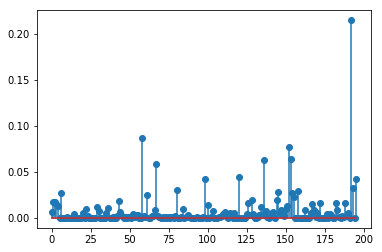

In [10]:
# TODO
ym = np.mean(ytr)
syy = np.mean((ytr-ym)**2)
Rsq = np.zeros(nneuron)
beta0 = np.zeros(nneuron)
beta1 = np.zeros(nneuron)
for k in range(nneuron):
    xm = np.mean(X0[:,k])
    sxy = np.mean((X0[:,k]-xm)*(y0-ym))
    sxx = np.mean((X0[:,k]-xm)**2)
    beta1[k] = sxy/sxx
    beta0[k] = ym - beta1[k]*xm
    Rsq[k] = (sxy)**2/sxx/syy   
    #print("{0:2d}  Rsq={1:f}".format(k,Rsq[k]))
    
plt.stem(Rsq)
plt.show()

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=100` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [11]:
d = 100  # Number of neurons to use

# TODO
Isel = np.argsort(Rsq)[::-1]
print("The neurons with the ten highest R^2 values =  \n",Isel[:10])

The neurons with the ten highest R^2 values =  
 [122 192  58 152 153 136  67 120 195  98]


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [12]:
# TODO
Xsel=X0[:,Isel[:d]]
ysel=y0[:]
regr=linear_model.LinearRegression()
regr.fit(Xsel,ysel)
ysel_pred = regr.predict(Xsel)
RSS_test = np.mean((ysel_pred-ysel)**2)/(np.std(ysel)**2)
Rsq_test = 1-RSS_test
print("RSS per sample = {0:.35f}".format(RSS_test))
print("R^2 = {0:.35f}".format(Rsq_test))

RSS per sample = 0.47528907983863732944485036568948999
R^2 = 0.52471092016136267055514963431051001


Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

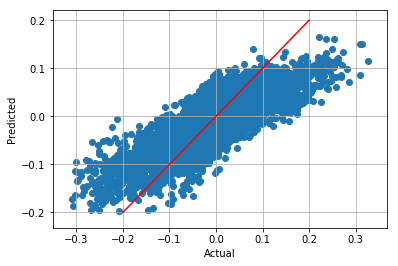

In [13]:
# TODO
plt.scatter(ysel,ysel_pred)
plt.plot([-0.2 ,0.2],[-0.2,0.2],'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=100`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

In [14]:
import  sklearn.model_selection 
import numpy.polynomial.polynomial as poly
# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)

# TODO.  
Indecies = np.argsort(-Rsq)
RSSts = np.zeros((nd,nfold))
for it, d in enumerate(dtest):
    Isel_d = Indecies[:d]
    X_d = X0[:,Isel_d]
    for isplit, Ind in enumerate(kf.split(X_d)):
        Itr,Its = Ind
        X_tr_k = X_d[Itr,:]
        y_tr_k = y0[Itr]
        X_ts_k = X_d[Its,:]
        y_ts_k = y0[Its]
        regd = sklearn.linear_model.LinearRegression()
        regd.fit(X_tr_k,y_tr_k)
        y_ts_pred_k = regd.predict(X_ts_k)
        RSSts[it,isplit] = np.mean((y_ts_k-y_ts_pred_k)**2)

Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method. 

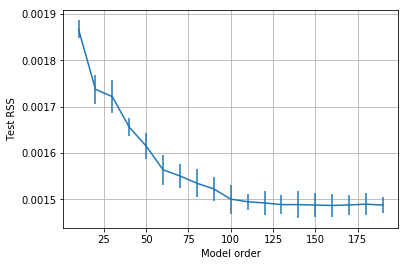

In [15]:
# TODO
RSS_mean = np.mean(RSSts,axis=1)
RSS_std  = np.std(RSSts,axis=1) / np.sqrt(nfold-1)
plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='-')
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [16]:
# TODO
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]
I = np.where(RSS_mean <= RSS_tgt)[0]
iopt = I[0]
dopt = dtest[iopt]
print("Optimal value of d: ",dopt)
print("Mean test RSS per sample at the optimal d: ", RSS_mean[iopt])

Optimal value of d:  100
Mean test RSS per sample at the optimal d:  0.00150016785753


## Using LASSO regression

Instead of using the above heuristic to select the variables, we can use LASSO regression.  

First use the `preprocessing.scale` method to standardize the data matrix `X0`.  Store the standardized values in `Xs`.  You do not need to standardize the response.  For this data, the `scale` routine may throw a warning that you are converting data types.  That is fine.

In [17]:
from sklearn import preprocessing

# TODO
Xs = preprocessing.scale(X0)
ys = sklearn.preprocessing.scale(y0)

C:\Users\Harris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Now, use the LASSO method to fit a model.  Use cross validation to select the regularization level `alpha`.  Use `alpha` values logarithmically spaced from `1e-5` to `0.1`, and use 10 fold cross validation.  

In [18]:
# TODO
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Create the LASSO model.  We use the `warm start` parameter so that the fit will start at the previous value.
# This speeds up the fitting.
model = linear_model.Lasso(warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-5,-1,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(Xs)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = Xs[Itr,:]
    y_tr = y0[Itr]
    X_ts = Xs[Its,:]
    y_ts = y0[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        model.alpha = a
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)

Plot the mean test RSS and test RSS standard error with the `plt.errorbar` plot.

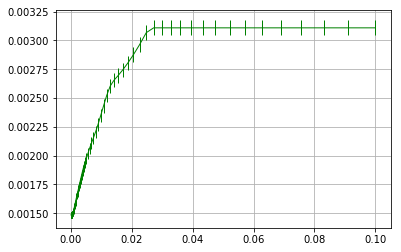

In [19]:
# TODO
mse_mean = np.mean(mse,axis=1)
mse_std = np.std(mse,axis=1) / np.sqrt(nfold-1)
plt.errorbar(alphas,mse_mean,fmt='g-',yerr=mse_std,linewidth=1)
plt.grid()
plt.show()

Find the optimal `alpha` and mean test RSS using the one standard error rule.

Optimal alpha = 0.000658


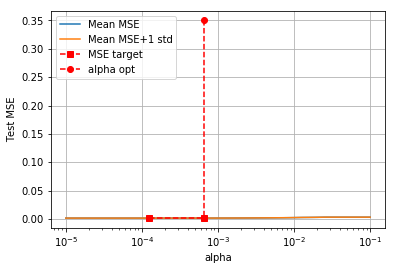

In [20]:
# TODO
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_std[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_mean)
plt.semilogx(alphas, mse_mean+mse_std)

# Plot the MSE target
plt.semilogx([alpha_min,alpha_opt], [mse_tgt,mse_tgt], 'rs--')

# Plot the optimal alpha line
plt.semilogx([alpha_opt,alpha_opt], [0.35,mse_mean[iopt]], 'ro--')

plt.legend(['Mean MSE', 'Mean MSE+1 std', 'MSE target','alpha opt'],loc='upper left')
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

Using the optimal alpha, recompute the predicted response variable on the whole data.  Plot the predicted vs. actual values.

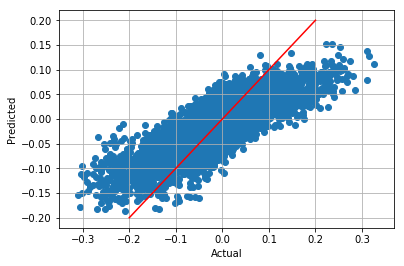

In [21]:
# TODO
model.alpha = alpha_opt
model.fit(Xs,y0)
yts_pred = model.predict(Xs)
plt.scatter(y0,yts_pred)
plt.plot([-0.2,0.2],[-0.2,0.2],'r-')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()

## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.